In [1]:
!nvidia-smi

Fri Feb 26 22:14:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content

/content


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-02-26 22:14:17--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.7MB/s    in 7.3s    

2021-02-26 22:14:25 (32.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
!unzip -q tiny-imagenet-200.zip

In [61]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q wandb

     |████████████████████████████████| 706kB 5.9MB/s 
     |████████████████████████████████| 2.0MB 5.7MB/s 
     |████████████████████████████████| 133kB 42.2MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 163kB 43.5MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 


In [5]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 8), reused 22 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [6]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [62]:
import tensorflow_addons as tfa

In [9]:
tf.keras.backend.set_image_data_format('channels_first')

In [10]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [13]:
import preprocessing

In [14]:
preprocessing.img_height, preprocessing.img_width = 64, 64
preprocessing.BATCH_SIZE = 512

In [15]:
# MOVE DATA LOADING TO FILES

In [16]:
TRAIN_PATH = "../tiny-imagenet-200/train/"
TEST_PATH = "../tiny-imagenet-200/test/"
VAL_PATH = "../tiny-imagenet-200/val/"

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

In [21]:
preprocessing.class_names = np.array(sorted([fp.split('/')[-1] for fp in glob.glob(TRAIN_PATH+"*")]))

In [22]:
preprocessing.val_labels = {}
with open(VAL_PATH+"val_annotations.txt") as fIn:
    reader = csv.reader(fIn, delimiter='\t')
    for row in reader:
        preprocessing.val_labels[row[0]] = row[1]

In [23]:
train_list_ds = (
    tf.data.Dataset.list_files(TRAIN_PATH+"*/images/*", shuffle=True)
    .map(preprocessing.process_train_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [24]:
val_list_ds = (
    tf.data.Dataset.list_files(VAL_PATH+"images/*")
    .map(preprocessing.process_val_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [25]:
mean = []
std = []
for a,b in train_list_ds.take(1024):
    mean.append(a.numpy())
    std.append(a.numpy())
mean = np.asarray(mean).mean(axis=(0,1,2)).reshape(1,3,1,1)
std = np.asarray(std).std(axis=(0,1,2)).reshape(1,3,1,1)

In [26]:
mean.ravel(), std.ravel()

(array([0.47682753, 0.45103166, 0.4013248 ], dtype=float32),
 array([0.2773205 , 0.26868924, 0.2811026 ], dtype=float32))

In [27]:
mean = tf.convert_to_tensor(mean)
std = tf.convert_to_tensor(std)

In [29]:
augmentation_layers = preprocessing.get_augmentation_layers()

In [31]:
train_ds = (
    train_list_ds
    .map(preprocessing.augment_wrapper, num_parallel_calls=AUTOTUNE)
    .batch(preprocessing.BATCH_SIZE)
    .map(lambda x, y: (augmentation_layers(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [32]:
val_ds = (
    val_list_ds
    .batch(preprocessing.BATCH_SIZE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [33]:
a, b = next(iter(train_ds))
a.shape

TensorShape([128, 3, 64, 64])

In [34]:
idx = np.random.randint(0,128)
x = a.numpy()[idx]
z = (x-x.min())/(x.max()-x.min())
z = z.transpose(1,2,0)
preprocessing.class_names[b[idx]]

'n04560804'

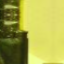

In [35]:
PIL.Image.fromarray((z*255).astype(np.uint8))

In [65]:
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [64]:
config_defaults = {
    'activation'            : 'leaky_relu',
    'dp_rate'               : 0.2,
    'batch_size'            : preprocessing.BATCH_SIZE,
    'norm'                  : 'bn',
    'self_attn'             : True,
    'frac_dk'               : 0.5,
    'frac_dv'               : 0.25,
    'pos_emb'               : True,
    'optimizer'             : 'adamw',
    'min_lr'                : 1e-5,
    'max_lr'                : 1e-3,
    'weight_decay'          : 1e-4,     #maximum
    'vary_weight_decay'     : True,
    'clr_step_size'         : 8,
    'loss_function'         : 'cce',
}

In [66]:
CONFIG = AttributeDict(config_defaults)

In [40]:
import conv_utils

In [41]:
conv_utils.CONFIG = CONFIG

In [50]:
inp = layers.Input(shape=(3,preprocessing.img_height, preprocessing.img_width))

In [51]:
x = conv_utils.conv_norm(inp, 8, kernel_size=5, strides=1, activation=CONFIG.activation)
x = conv_utils.conv_norm(x, 32, kernel_size=3, strides=2, activation=CONFIG.activation,
                    do_norm_act=False)

In [52]:
x = conv_utils.down_stack(x, fltrs=[ 8,16,16], self_attn=False, dp_rate=CONFIG.dp_rate)   # (64, 16, 16)
x = conv_utils.down_stack(x, fltrs=[16,32,32], self_attn=[False, True, True], dp_rate=CONFIG.dp_rate)   # (128, 8, 8)
x = conv_utils.down_stack(x, fltrs=[32,64,64], self_attn=True, dp_rate=CONFIG.dp_rate)   # (256, 4, 4)

In [53]:
x = conv_utils.conv_norm(x, 512, kernel_size=3, strides=1, activation=CONFIG.activation)
x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
if CONFIG.dp_rate:
    x = layers.Dropout(CONFIG.dp_rate)(x)
x = layers.Dense(len(preprocessing.class_names))(x)
x = layers.Softmax(axis=1)(x)

In [54]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 8, 64, 64)    608         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 8, 64, 64)    32          conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 8, 64, 64)    0           batch_normalization_29[0][0]     
____________________________________________________________________________________________

In [ ]:
ret = tf.keras.utils.plot_model(model, to_file='model.svg', show_shapes=True, dpi=None)

In [56]:
# wandb.log({"model": wandb.Image("model.png")})

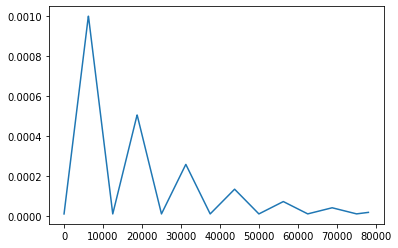

In [63]:
steps_per_epoch = len(train_ds)
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
            initial_learning_rate=CONFIG.min_lr,
            maximal_learning_rate=CONFIG.max_lr,
            step_size=CONFIG.clr_step_size * steps_per_epoch,
            scale_mode="cycle")
domain = range(0, 50*steps_per_epoch, 32)
lr_log = [clr(i).numpy() for i in domain]
plt.plot(domain, lr_log)
plt.show()

In [67]:
def get_wdc(i):
    wdc = CONFIG.weight_decay*clr(i)/CONFIG.max_lr
    if tf.executing_eagerly():
        return wdc.numpy()
    else:
        return wdc

In [68]:
if CONFIG.optimizer == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=clr, weight_decay=lambda : CONFIG.weight_decay)
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)    # weight_decay=lambda : None
    if CONFIG.vary_weight_decay:
        opt.weight_decay = lambda : get_wdc(opt.iterations)
elif CONFIG.optimizer == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [70]:
if CONFIG.loss_function == 'cce':
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [71]:
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[])#wandb_cb])

Epoch 1/50
782/782 [==============================] - 212s 246ms/step - loss: 5.3073 - accuracy: 0.0103 - val_loss: 5.3930 - val_accuracy: 0.0224
Epoch 2/50
782/782 [==============================] - 119s 152ms/step - loss: 4.9289 - accuracy: 0.0316 - val_loss: 5.8222 - val_accuracy: 0.0234
Epoch 3/50
 52/782 [>.............................] - ETA: 1:45 - loss: 4.7687 - accuracy: 0.0520

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
# wandb.login()

In [ ]:
# run = wandb.init(project="tiny-imagenet-test", entity="shivamshrirao", config=config_defaults)
# CONFIG = wandb.config